# Graph Statistics

In [22]:
import os
from graph import GraphIO
import networkx as nx
from networkx.algorithms.components import number_strongly_connected_components as ncc_strong
from networkx.algorithms.components import number_weakly_connected_components as ncc_weak
import matplotlib.pyplot as plt
import matplotlib.patches as ptch
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
import pandas as pd

In this notebook, I will show how to obtain basic graph statistics (number of nodes, density, etc.) from the graphs stored in our filespec.

## Load the Graphs

In this study, we extracted data from five different connectome datasets. The first, identified as "worm wiring" or "worm" consists of both a hermaphroditic and male c. elegans connectome ({cite}`cook_whole-animal_2019`, https://wormwiring.org/).  The second, identified as "witvliet" or "wit" consists of 8 different hermaphrodite c. elegans connectomes at different developmental ages ({cite}`witvliet_connectomes_2020`, https://nemanode.org/).  The third, identified as "ciona" consists of a single connectome of a ciona intestinalis larva ({cite}`ryan_cns_2016`).  The fourth, identified as "fafb" consists of a single connectome of a female adult fly brain ({cite}`zheng_complete_2018`, https://temca2data.org/).  The fifth and final dataset consists of a portion of an adult female fly brain ({cite}`xu_connectome_2020`, https://www.janelia.org/project-team/flyem/hemibrain).  For more thorough analysis, graphs are subdivided into chemical and electrical synapses.

In [30]:
script_dir = os.getcwd()
base_path = os.path.join(script_dir, "json_connectomes")

worm_graphs = []
worm_path = os.path.join(base_path, "worm_wiring/connectome")
for graph_folder in os.listdir(worm_path):
    if graph_folder.startswith("."):
        continue
    graph_folder_path = os.path.join(worm_path, graph_folder)
    for graph_file in os.listdir(graph_folder_path):
        graph_file_path = os.path.join(graph_folder_path, graph_file)
        graph, _, _, _ = GraphIO.load(graph_file_path)
        worm_graphs.append(graph)

wit_graphs = []
wit_path = os.path.join(base_path, "witvilet")
for graph_file in os.listdir(wit_path):
    path = os.path.join(wit_path, graph_file)
    graph, _, _, _ = GraphIO.load(path)
    wit_graphs.append(graph)
    
wit_subgraphs = []
for graph in wit_graphs:
    chemical_edges = []
    electrical_edges = []
    for *edge, attr in graph.edges(data=True, keys=True):
        if attr['synapse_type'] == "chemical":
            chemical_edges.append((*edge,))
        elif attr['synapse_type'] == "electrical":
            electrical_edges.append((*edge,))
    g_chemical = nx.Graph.copy(graph.edge_subgraph(chemical_edges))
    g_chemical.graph["Synapse Type"] = "Chemical"
    g_electrical = nx.Graph.copy(graph.edge_subgraph(electrical_edges))
    g_electrical.graph["Synapse Type"] = "Total Gap Junction"
    wit_subgraphs.extend([g_chemical, g_electrical])

ciona_path = os.path.join(base_path, "ciona.json")
fafb_path = os.path.join(base_path, "fafb.json")
neuPrint_path = os.path.join(base_path, "neuPrint_graphs.json")
ciona_graph, _, _, _ = GraphIO.load(ciona_path)
fafb_graph, _, _, _ = GraphIO.load(fafb_path)
neuPrint_graph, _, _, _ = GraphIO.load(neuPrint_path)

# Assign Sex and Synapse Type to ciona, fafb, and neuPrint (to be removed later)

In [31]:
ciona_graph.graph["Sex"] = "Hermaphrodite"
ciona_graph.graph["Synapse Type"] = "Mixed"
fafb_graph.graph["Sex"] = "Female"
fafb_graph.graph["Synapse Type"] = "Chemical"
neuPrint_graph.graph["Sex"] = "Female"
neuPrint_graph.graph["Synapse Type"] = "Chemical"

## Obtain Graph Statistics and Metadata

Basic graph statistics such as density and graph size are useful measures to obtain an intuitive sense of the relevant qualities of each connectome, although they are not useful for statistically rigorous comparison due to the correlation of many statistics with each other.  The degree distributions are also useful exploratory metrics to see how the neurons are connected to each other within each connectome.

In [43]:
statnames = ["lcc_size", "density", "num_strong", "num_weak",
             "in_degree", "out_degree", "synapse_type", "sex", "graph_origin"]
stats = {statname:[] for statname in statnames}

def append_stats(g, stats):
    stats["lcc_size"].append(len(max(nx.weakly_connected_components(g))))
    stats["density"].append(nx.density(g))
    stats["num_strong"].append(ncc_strong(g))
    stats["num_weak"].append(ncc_weak(g))
    stats["in_degree"].append([d for n, d in g.in_degree()])
    stats["out_degree"].append([d for n, d in g.out_degree()])
    stats["synapse_type"].append(g.graph['Synapse Type'])
    stats["sex"].append(g.graph['Sex'])
    
digraphs = [worm_graphs, wit_subgraphs, [fafb_graph], [neuPrint_graph]]
digraph_origins = ["worm", "wit", "fafb", "neuPrint"]
for graphs, origin in zip(digraphs, digraph_origins):
    for g in graphs:
        stats["graph_origin"].append(origin)
        append_stats(g, stats)
    
#ciona uses slightly different functions since it is undirected
stats["graph_origin"].append("ciona")
stats["lcc_size"].append(len(max(nx.connected_components(ciona_graph))))
stats["density"].append(nx.density(ciona_graph))
stats["num_strong"].append(nx.number_connected_components(ciona_graph))
stats["num_weak"].append(nx.number_connected_components(ciona_graph))
stats["in_degree"].append([d for n, d in ciona_graph.degree()])
stats["out_degree"].append([d for n, d in ciona_graph.degree()])
stats["synapse_type"].append(ciona_graph.graph["Synapse Type"])
stats["sex"].append(ciona_graph.graph["Sex"])

stats["max_in_degree"] = [max(stats["in_degree"][i]) for i, _ in enumerate(stats["in_degree"])]
stats["max_out_degree"] = [max(stats["out_degree"][i]) for i, _ in enumerate(stats["out_degree"])]
stats = pd.DataFrame(stats)
print(stats)

    lcc_size   density  num_strong  num_weak  \
0        446  0.023723         163         9   
1        460  0.006606         469         9   
2        460  0.013135           9         9   
3        559  0.016076         220        17   
4         57  0.005128         586        46   
5         57  0.010157          46        46   
6        221  0.045290          63         1   
7        163  0.008834         182        10   
8        219  0.045788          61         1   
9        154  0.012186         160         5   
10       187  0.022282          85         1   
11        28  0.009701          93        18   
12       193  0.026608          72         1   
13        86  0.009295         116        14   
14       198  0.025945          75         1   
15        62  0.010307          96        14   
16       203  0.027703          76         1   
17       111  0.011383         136        11   
18       210  0.034518          60         1   
19       151  0.012233         155      

## Visualize 

We visualize each graph statistic for all the extracted graphs, making note of relevant properties such as synapse type and sex.

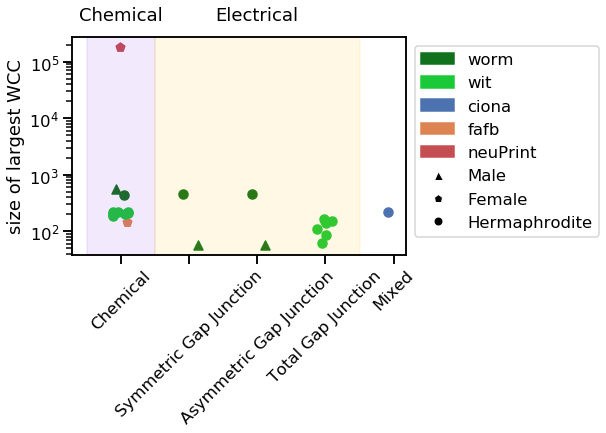

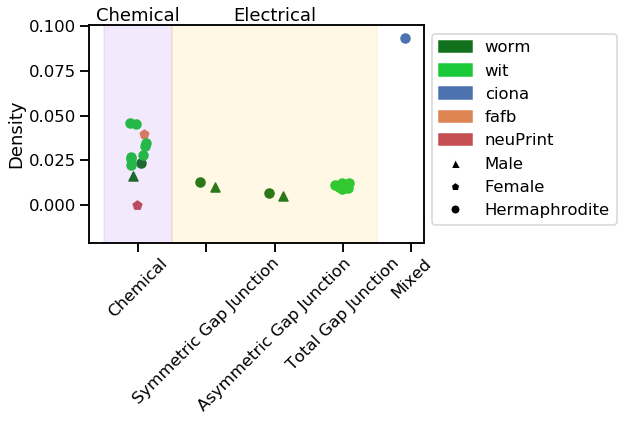

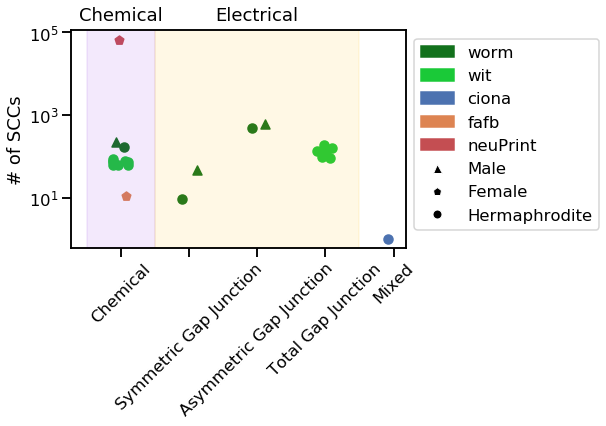

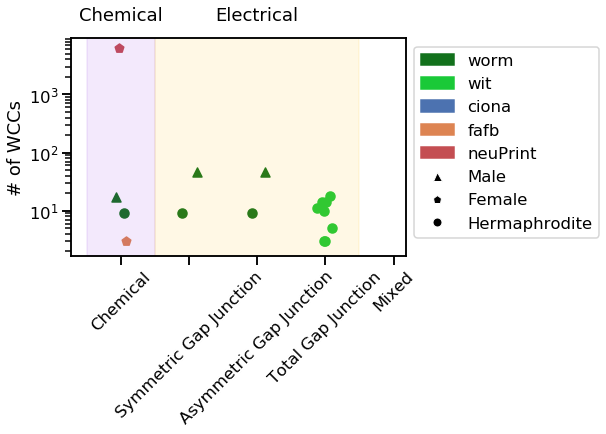

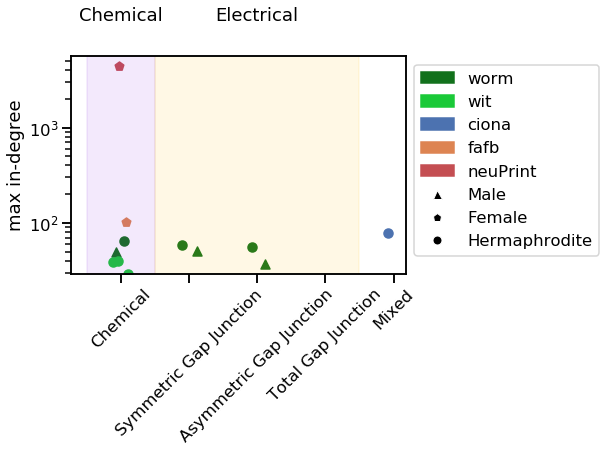

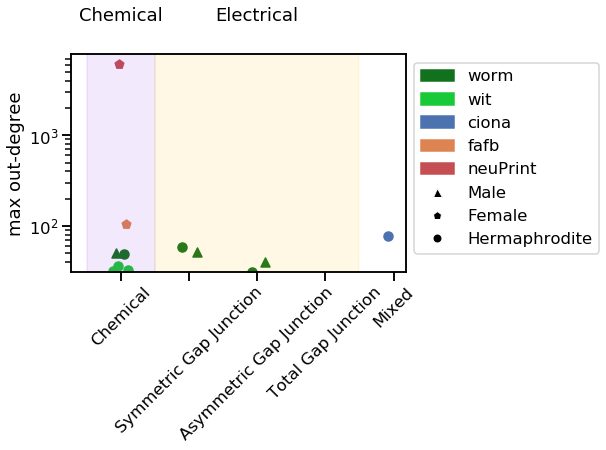

In [44]:
palette = sns.color_palette("deep")
dark_palette = sns.color_palette("dark")
bright_palette = sns.color_palette("bright")

syntypes = ["Chemical", "Symmetric Gap Junction", "Asymmetric Gap Junction", "Total Gap Junction", "Mixed"]
graph_origins = ["worm", "wit", "ciona", "fafb", "neuPrint"]
syntype_pos = [float(i) for i, _ in enumerate(syntypes)]
syntype2pos = {syntype:i for i, syntype in zip(syntype_pos, syntypes)}
syn_pos = np.array([syntype2pos[syntype] for syntype in stats.synapse_type])
syn_pos += 0.25*(np.random.rand(syn_pos.shape[0]) - 0.5) #adding jitter
sexes = ["Male", "Female", "Hermaphrodite"]
sex2shape = {"Male":"^", "Hermaphrodite":"o", "Female":"p"}
graph2color = {"ciona":palette[0], "fafb":palette[1], "worm":dark_palette[2], "wit":bright_palette[2], "neuPrint":palette[3]}
graph2patch = {}
for g_origin in graph_origins:
    graph2patch[g_origin] = ptch.Patch(color=graph2color[g_origin], label=g_origin)
sex2patch = {}
for isex in sexes:
    sex2patch[isex] = Line2D([0], [0], marker=sex2shape[isex], color="w", markerfacecolor="k", label=isex)

def vis_stat(stat, stat_name, use_log=True):
    fig_max = np.max(stat)
    sns.set_context('talk')
    fig = plt.figure()
    ax = plt.gca()
    plt.hold=True
    for isex in sexes:
        for g_origin in graph_origins:
            mask = np.logical_and(stats.sex==isex, stats.graph_origin==g_origin)
            plt.scatter(syn_pos[mask],
                        stat[mask],
                        c=np.array([graph2color[g_origin]]),
                        label=g_origin,
                        marker=sex2shape[isex])
    grace_factor = 1.1
    if use_log:
        grace_factor = np.exp(grace_factor)
    plt.text(syntype_pos[0], grace_factor*fig_max, "Chemical", ha="center")
    plt.text(syntype_pos[2], grace_factor*fig_max, "Electrical", ha="center")
    plt.hold=False
    plt.ylabel(stat_name)
    ax.xaxis.set_ticks(syntype_pos)
    ax.xaxis.set_ticklabels(syntypes, rotation=45)
    fill_width = 1
    ax.axvspan(syntype_pos[0]-fill_width/2, syntype_pos[0]+fill_width/2, color=bright_palette[4], alpha=0.1)
    ax.axvspan(syntype_pos[1]-fill_width/2, syntype_pos[3]+fill_width/2, color=bright_palette[8], alpha=0.1)
    if use_log:
        ax.set_yscale("log")
    handles = [graph2patch[g_origin] for g_origin in graph_origins]+[sex2patch[isex] for isex in sexes]
    plt.legend(handles=handles, bbox_to_anchor=(1,1))
    return fig
    
vis_stat(stats.lcc_size, "size of largest WCC")
vis_stat(stats.density, "Density", use_log=False)
vis_stat(stats.num_strong, "# of SCCs")
vis_stat(stats.num_weak, "# of WCCs")
vis_stat(stats.max_in_degree, "max in-degree")
_ = vis_stat(stats.max_out_degree, "max out-degree")

Notice how the neuPrint graph is much bigger than the others, and so generally diverges on a variety of metrics.

## Visualize Degree Distributions

We also visualize degree distributions in the same way.

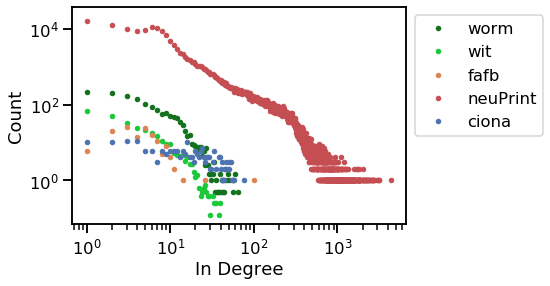

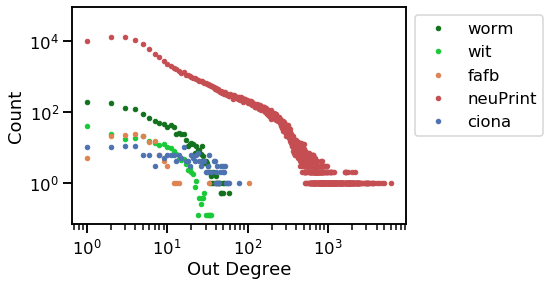

In [45]:
def vis_degree_dist(dd, graph_origin, sex, dd_name):
    dd_plot = []
    dd_labels = []
    
    #Aggregating worm_wiring and witvilet graphs
    worm = sum(dd[graph_origin=="worm"], [])
    worm_dd, _ = np.histogram(worm, bins=max(worm))
    worm_dd = worm_dd/2 #average over sex
    dd_plot.append(worm_dd)
    dd_labels.append("worm")
    wit = sum(dd[graph_origin=="wit"], [])
    wit_dd, _ = np.histogram(wit, bins=max(wit))
    wit_dd = wit_dd / len(wit_graphs) #average over age
    dd_plot.append(wit_dd)
    dd_labels.append("wit")
    
    for i, ddi in enumerate(dd):
        if graph_origin[i] != "wit" and graph_origin[i]!="worm":
            hist, _ = np.histogram(ddi, bins=int(max(ddi)))
            dd_plot.append(hist)
            dd_labels.append(graph_origin[i])
    #plot
    fig = plt.figure()
    plt.hold = True
    for ddi, dd_label in zip(dd_plot, dd_labels):
        plt.plot(ddi, ".", color=graph2color[dd_label], label=dd_label)
    plt.hold = False
    plt.xlabel(dd_name)
    plt.ylabel("Count")
    plt.legend(bbox_to_anchor=(1, 1))
    plt.yscale("log")
    plt.xscale("log")
    return fig

vis_degree_dist(stats.in_degree, stats.graph_origin, stats.sex, "In Degree")
_ = vis_degree_dist(stats.out_degree, stats.graph_origin, stats.sex, "Out Degree")

Now, it is clear that the ciona counts remain relatively uniform as degree increases, but all the other graphs decline sharply as degree increases.

# Witvliet-specific graphs

Since the witvliet dataset has 8 c. elegans connectomes, each with a different age, we can visualize how the connectomes change with age.

In [46]:
ages = []
for g in wit_graphs:
    ages.append(g.graph['age'])
ages = np.array(ages)

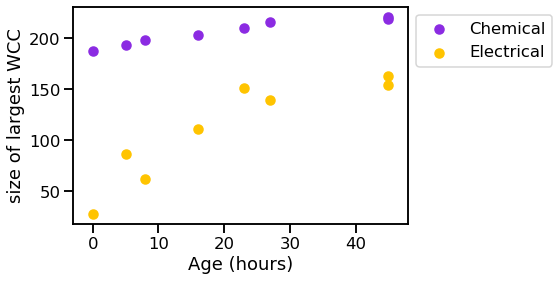

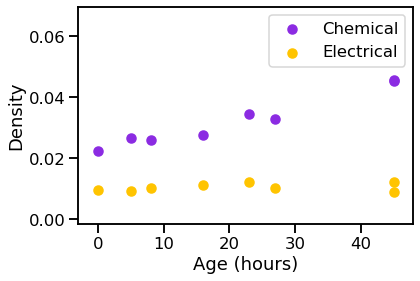

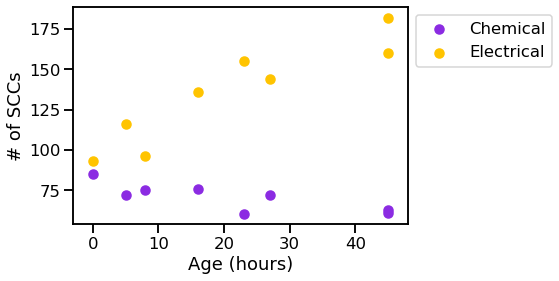

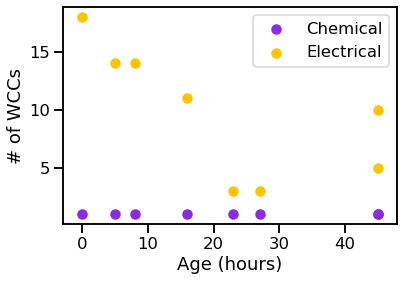

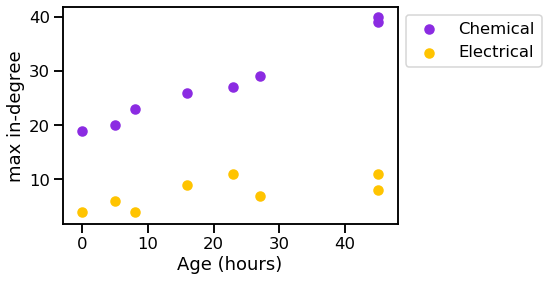

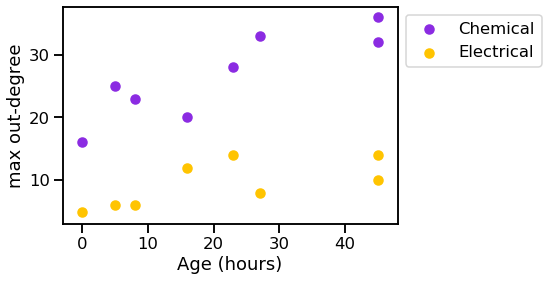

In [49]:
syntypes = ["Chemical", "Symmetric Gap Junction", "Asymmetric Gap Junction", "Total Gap Junction"]
syntype2color = {"Chemical":bright_palette[4], "Total Gap Junction":bright_palette[8]}
def vis_stat(stat, stat_name):
    fig_max = np.max(stat)
    fig = plt.figure()
    ax = plt.gca()
    plt.hold=True
    for syntype, synlabel in zip(["Chemical", "Total Gap Junction"], ["Chemical", "Electrical"]):
        plt.scatter(ages,
                    stat[np.logical_and(stats.synapse_type==syntype, stats.graph_origin=="wit")],
                    c=np.array([syntype2color[syntype]]),
                    marker=sex2shape[wit_graphs[0].graph["Sex"]],
                    label=synlabel)
    plt.hold=False
    plt.xlabel("Age (hours)")
    plt.ylabel(stat_name)
    plt.legend(bbox_to_anchor=(1,1))
    return fig
    
vis_stat(stats.lcc_size,  "size of largest WCC")
vis_stat(stats.density, "Density")
vis_stat(stats.num_strong, "# of SCCs")
vis_stat(stats.num_weak, "# of WCCs")
vis_stat(stats.max_in_degree, "max in-degree")
_ = vis_stat(stats.max_out_degree, "max out-degree")

We can see that the graphs generally get bigger over time, and the chemical synapses grow more dense, while the density of the electrical synapses remains relatively constant.

## Degree Distributions

We also visualize the degree distributions the same way.

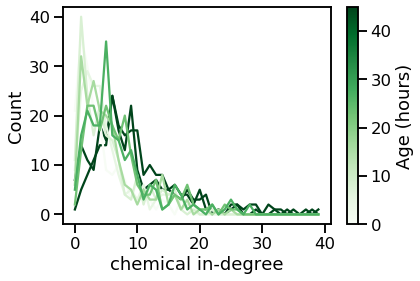

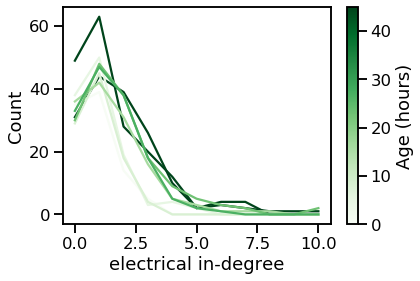

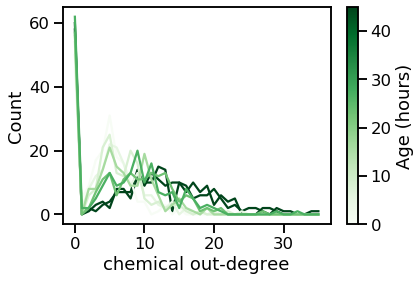

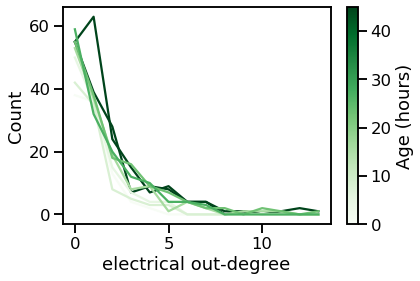

In [52]:
def vis_degree_dist(dd, max_degree, ages, dd_name):
    max_max_degree = max(max_degree)
    dd_x = np.array(range(max_max_degree))
    dd_z = []
    for ddi in dd:
        hist, _ = np.histogram(ddi, bins=max(ddi))
        hist = np.pad(hist, (0, max_max_degree-max(ddi)))
        dd_z.append(hist)
    dd_z = np.transpose(np.array(dd_z))
    
    cm = plt.cm.get_cmap('Greens')
    colors = cm(ages/max(ages))
    fig = plt.figure()
    plt.hold = True
    for i, age in enumerate(ages):
        plt.plot(dd_x, dd_z[:, i], c=colors[i])
    sm = plt.cm.ScalarMappable(cmap=cm, norm=plt.Normalize(vmin=min(ages), vmax=max(ages)))
    plt.colorbar(sm, label="Age (hours)")
    plt.xlabel(dd_name)
    plt.ylabel("Count")
    plt.hold = False
    return fig

chem_ins = stats.in_degree[np.logical_and(stats.graph_origin=="wit", stats.synapse_type=="Chemical")]
chem_in_maxes = stats.max_in_degree[np.logical_and(stats.graph_origin=="wit", stats.synapse_type=="Chemical")]
vis_degree_dist(chem_ins, chem_in_maxes, ages, "chemical in-degree")

elec_ins = stats.in_degree[np.logical_and(stats.graph_origin=="wit", stats.synapse_type=="Total Gap Junction")]
elec_in_maxes = stats.max_in_degree[np.logical_and(stats.graph_origin=="wit", stats.synapse_type=="Total Gap Junction")]
vis_degree_dist(elec_ins, elec_in_maxes, ages, "electrical in-degree")

chem_outs = stats.out_degree[np.logical_and(stats.graph_origin=="wit", stats.synapse_type=="Chemical")]
chem_out_maxes = stats.max_out_degree[np.logical_and(stats.graph_origin=="wit", stats.synapse_type=="Chemical")]
vis_degree_dist(chem_outs, chem_out_maxes, ages, "chemical out-degree")

elec_outs = stats.out_degree[np.logical_and(stats.graph_origin=="wit", stats.synapse_type=="Total Gap Junction")]
elec_out_maxes = stats.max_out_degree[np.logical_and(stats.graph_origin=="wit", stats.synapse_type=="Total Gap Junction")]
_ = vis_degree_dist(elec_outs, elec_out_maxes, ages, "electrical out-degree")

From these plots, we can tell that the degree distribution remains relatively static across age.

## References

```{bibliography}
```